In [25]:
from utils_experiment_1800 import (
    load_data,
    filter_data_exp_1,
    AutoGluonProcessor,
    fit_predictors_local,
    fit_predictors_global,
    get_model_list,
    create_output_directories,
    process_and_plot_forecasts,
)

In [26]:
import torch
print("Is cuda available? {}".format(torch.cuda.is_available()))
torch.cuda.get_device_name(torch.cuda.current_device())

Is cuda available? True


'Tesla T4'

## Experiment 1 Details

Experiment 1 serves as a baseline for comparing the effect of different window lengths for training. The data will be filtered to include only time series that are available in the time period. To investiage the effect of the time series by themselves, the number of covariates is kept constant across all time series and corresponds to the time series fully available from 1986. The specific time periods were chosen with the condition that between each interval, 5 or more new time series were introduced.

| Time Period - 2024     | Maximum number of covariates | Number of covariates used |
|--------------|:-----:| :-----:| 
| 1986 |   94  |   94  |  
| 1997 |   111  |  94  |  
| 2004 |   133  |   94  |  
| 2007 |   146  |  94  |  
| 2010 |   154  |  94  |  
| 2018 |   159  |  94  |  


The cut-off dates are set at 4 yearly intervals between 2020 and 2024. Since the minimum training length for a yearly interval is 2 years, 2020 is the earliest cut-off date we can use.


In [27]:
exp_test_description = "Forecasts"
report_sim_dates= ['2024-07-01']

target_categories = [
    'Bakery and cereal products (excluding baby food)',
     'Dairy products and eggs',
     'Fish, seafood and other marine products',
     'Food purchased from restaurants',
     'Food',
     'Fruit, fruit preparations and nuts',
     'Meat',
     'Other food products and non-alcoholic beverages',
     'Vegetables and vegetable preparations'
]

target_categories = [f"food_cpi: {col}" for col in target_categories]

start_year = 1986
random_seed = 42

print("Target Categories:\n" + '\n'.join(target_categories))
print("Report Simulation Dates:\n" + '\n'.join(report_sim_dates))


Target Categories:
food_cpi: Bakery and cereal products (excluding baby food)
food_cpi: Dairy products and eggs
food_cpi: Fish, seafood and other marine products
food_cpi: Food purchased from restaurants
food_cpi: Food
food_cpi: Fruit, fruit preparations and nuts
food_cpi: Meat
food_cpi: Other food products and non-alcoholic beverages
food_cpi: Vegetables and vegetable preparations
Report Simulation Dates:
2024-07-01


## Load data

`all_data`: dataframe with all the food cpi variables and all the covariates from 1986 to 2024.\
`foodprice_df`: dataframe with only the food cpi variables from 1986 to 2024.\
`target_categories`: list of the names of the food cpi variables.\
`all_covariates`: dataframe with all the covariates from 1986 to 2024.

In [28]:
file_path = "/h/kupfersk/cfpr_2025/data/processed_data/all_data_processed.csv"
all_data, foodprice_df, target_categories, all_covariates = load_data(target_categories, file_path)
all_data = all_data.fillna(method='bfill')
all_covariates = all_covariates.fillna(method='bfill')

In [29]:
all_data

,swe_sj: SWE,swe_sr: SWE,policy_uncertainty: Canada News-Based Policy Uncertainty Index,apu000072610: APU000072610,ces0500000011: CES0500000011,cwur0000sa0: CWUR0000SA0,excaus: EXCAUS,fedfunds: FEDFUNDS,fmpi: PCU311311,impca: IMPCA,...,commodity_price_index: FATS_OILS,commodity_price_index: GRAINS,commodity_price_index: OTHERFOOD,commodity_price_index: RAW_MATERIAL,commodity_price_index: TIMBER,commodity_price_index: OTHERRAWMAT,commodity_price_index: FERTILIZERS,commodity_price_index: METMIN,commodity_price_index: BASEMET,commodity_price_index: PRECIOUSMET
1986-01-01,10.753226,14.725986,91.105314,0.081,685.71,108.900,1.4070,6.56,99.800,5680.700000,...,43.90,53.49,42.38,41.00,42.52,39.34,30.05,28.20,30.57,28.46
1986-02-01,18.899366,26.887587,96.968702,0.075,685.71,108.500,1.4043,6.56,99.200,5659.500000,...,40.42,51.66,44.31,42.09,43.24,40.83,29.26,27.99,30.32,27.80
1986-03-01,23.348971,39.425513,86.906782,0.075,685.71,107.900,1.4009,6.56,99.000,5922.900000,...,39.30,50.81,48.52,41.13,41.96,40.21,29.52,28.87,31.39,28.08
1986-04-01,16.509811,38.585833,69.223383,0.074,685.71,107.600,1.3879,6.56,98.600,5821.100000,...,38.32,49.90,50.99,39.79,40.85,38.64,28.63,28.62,31.09,27.35
1986-05-01,10.428860,25.978136,93.354333,0.074,685.71,107.900,1.3757,6.56,99.300,5922.500000,...,37.96,49.04,47.12,40.42,42.57,38.07,27.89,28.63,31.10,27.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,20.660710,14.939886,248.883113,0.175,1197.07,308.163,1.3667,5.33,257.218,35669.381089,...,106.75,119.29,131.97,76.86,78.39,75.20,108.45,116.64,124.80,178.99
2024-06-01,2.536432,0.934703,195.109713,0.178,1200.50,308.054,1.3705,5.33,258.949,34393.224478,...,107.00,115.64,125.32,77.03,78.62,75.29,118.20,110.62,119.21,177.56
2024-07-01,1.010973,0.523842,223.075369,0.178,1199.39,308.501,1.3714,5.33,260.250,35798.948016,...,107.81,109.08,126.19,80.58,79.35,81.94,120.34,106.84,114.64,182.29
2024-08-01,0.981405,0.329099,295.164116,0.177,1208.39,308.640,1.3655,5.33,259.876,33036.375028,...,102.35,106.34,127.40,78.25,80.90,75.35,120.02,103.50,111.63,185.63


In [30]:
foodprice_df

,food_cpi: Bakery and cereal products (excluding baby food),food_cpi: Dairy products and eggs,"food_cpi: Fish, seafood and other marine products",food_cpi: Food purchased from restaurants,food_cpi: Food,"food_cpi: Fruit, fruit preparations and nuts",food_cpi: Meat,food_cpi: Other food products and non-alcoholic beverages,food_cpi: Vegetables and vegetable preparations
1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,76.0
1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,68.4
1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,66.2
1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1
1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3
...,...,...,...,...,...,...,...,...,...
2024-05-01,198.8,171.0,160.8,194.2,189.0,168.8,210.2,177.9,189.7
2024-06-01,198.2,173.7,161.0,195.0,190.0,171.0,211.3,178.5,190.2
2024-07-01,199.1,174.4,162.1,195.3,190.5,168.8,212.8,177.9,194.7
2024-08-01,198.4,174.4,162.1,195.5,190.3,168.3,212.5,179.5,189.8


In [31]:
processor = AutoGluonProcessor(all_data, target_categories)


# Experiment List

| AutoGluon Model \ Experiment      | local | global | global + covariates |
|--------------|:-----:| :-----: | :-----: |
| NaiveModel |   x  |   |  | 
| SeasonalNaiveModel|   x    |  |  | 
| AutoARIMAModel|   x   |  |  | 
| AutoETSModel|  x  |    |  | 
| DeepARModel|  x   | x |  x | 
| DLinearModel| x   | x |  x| 
| PatchTSTModel|  x   | x | x |   
|SimpleFeedForwardModel|  x   | x | x |   
| TemporalFusionTransformerModel| x  | x | x |   
| DirectTabularModel| x   | x | x | 
|RecursiveTabularModel|  x   | x | x |  
|ChronosModel|  x   | x | x | 

x - model type supported


## Main experiment loop - local models

4 main loops:
- The first loop goes through the list of years at which we want the time window to start, filters out the covariates that are not fully available from 1986.
- The second loop goes though each of the 12 Autogluon models.
- The third loop goes through each of the yearly cut-off dates to trim the training data.
- The fourth loop goes through each of the 9 food categories, gets the training data in the AutoGluon format for local models and plot each prediction period againt the actual values.

In [32]:
# EXP_BASE = "ag_local"
# EXP_MODEL_LIST = get_model_list(EXP_BASE)


# for model_type in EXP_MODEL_LIST:
#     EXPERIMENT_NAME = f"{EXP_BASE}_{model_type}"
    
# #     if 'Chronos' not in model_type:
# #         continue

#     for cutoff_date in report_sim_dates:
#         forecast_output_dir, plot_output_dir, training_output_dir, model_dir = (
#             create_output_directories(
#                 exp_test_description,
#                 start_year,
#                 EXPERIMENT_NAME,
#                 cutoff_date,
#                 random_seed
#             )
#         )

#         for category in target_categories:
#             train_data = processor.get_autogluon_local_df(category, cutoff_date)
#             predictor = fit_predictors_local(model_type, model_dir, train_data, category, random_seed)
#             process_and_plot_forecasts(
#                 predictor,
#                 train_data,
#                 category,
#                 training_output_dir,
#                 forecast_output_dir,
#                 plot_output_dir,
#                 foodprice_df,
#                 cutoff_date
#             )

# Main experiment loop - global models

5 main loops:
- The first loop goes through the list of years at which we want the time window to start, filters out the covariates that are not fully available from 1986.
- The second loop goes though the two experiment base (global and global+covariates)
- The third loop goes though 8 Autogluon models, excluding all statistical models (Naive, SeasonalNaive, AutoArima, AutoETS).
- The fourth loop goes through each of the yearly cut-off dates to trim the training data.
- The fifth loop goes through each of the 9 food categories, gets the training data in the AutoGluon format depending on the experiment base and plot each prediction period againt the actual values.

In [33]:
# EXP_BASE_LIST_GLOBAL = ["ag_global_all", "ag_global_cpi_with_covariates"]




# for EXP_BASE in EXP_BASE_LIST_GLOBAL:
#     EXP_MODEL_LIST = get_model_list(EXP_BASE)
#     print(EXP_MODEL_LIST)

#     for model_type in EXP_MODEL_LIST:
#         print(model_type)
        
        
#         EXPERIMENT_NAME = f"{EXP_BASE}_{model_type}"

#         for cutoff_date in report_sim_dates:
#             forecast_output_dir, plot_output_dir, training_output_dir, model_dir = (
#                 create_output_directories(
#                     exp_test_description,
#                     start_year,
#                     EXPERIMENT_NAME,
#                     cutoff_date,
#                     random_seed
#                 )
#             )

#             if "_covariates" in EXP_BASE:
#                 train_data = processor.get_autogluon_global_with_covariates_df(
#                     cutoff_date
#                 )
#             else:
#                 train_data = processor.get_autogluon_global_df(cutoff_date)

#             predictor = fit_predictors_global(model_type, model_dir, train_data, random_seed)

#             for category in target_categories:
#                 process_and_plot_forecasts(
#                     predictor,
#                     train_data,
#                     category,
#                     training_output_dir,
#                     forecast_output_dir,
#                     plot_output_dir,
#                     foodprice_df,
#                     cutoff_date
#                 )

['TemporalFusionTransformerModel']
TemporalFusionTransformerModel


Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/Forecasts/ag_global_cpi_with_covariates_TemporalFusionTransformerModel/random_seed_42/2024-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       143.21 GB / 188.59 GB (75.9%)
Disk Space Avail:   18162.75 GB / 249006.62 GB (7.3%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'TemporalFusionTransformerModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 '

TemporalFusionTransformerModel


	past_covariates:
		categorical:        []
		continuous (float): ['exogenous_swe_sj: SWE', 'exogenous_swe_sr: SWE', 'exogenous_po...rtainty Index', 'exogenous_ap... APU000072610', 'exogenous_ce...CES0500000011', 'exogenous_cw...: CWUR0000SA0', ...]

To learn how to fix incorrectly inferred types, please see documentation for TimeSeriesPredictor.fit

AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-10-26 10:32:29
Excluded model types: ['DirectTabular', 'RecursiveTabular']
Models that will be trained: ['TemporalFusionTransformer']
Training timeseries model TemporalFusionTransformer. Training for up to 1799.9s of the 1799.9s of remaining time.
	-0.0321       = Validation score (-MAPE)
	236.49  s     = Training runtime
	0.24    s     = Validation (prediction) runtime
Not fitting ensemble

****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.032127       0.244802         236.488763   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


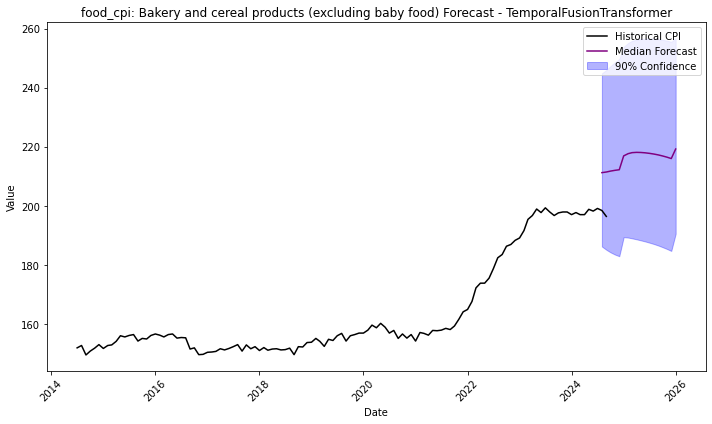

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.032127       0.244802         236.488763   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


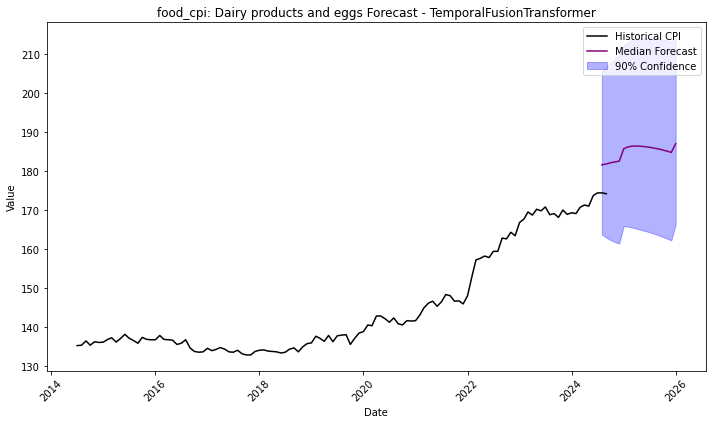

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.032127       0.244802         236.488763   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


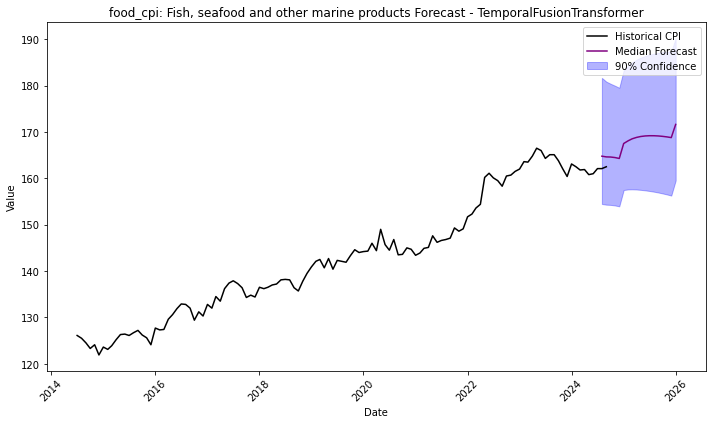

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.032127       0.244802         236.488763   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


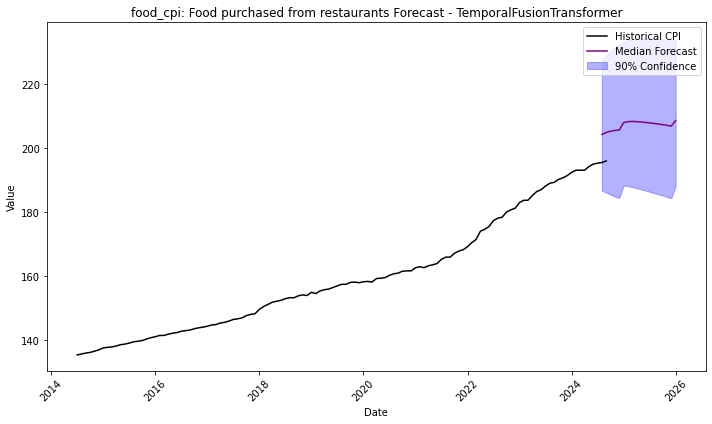

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.032127       0.244802         236.488763   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


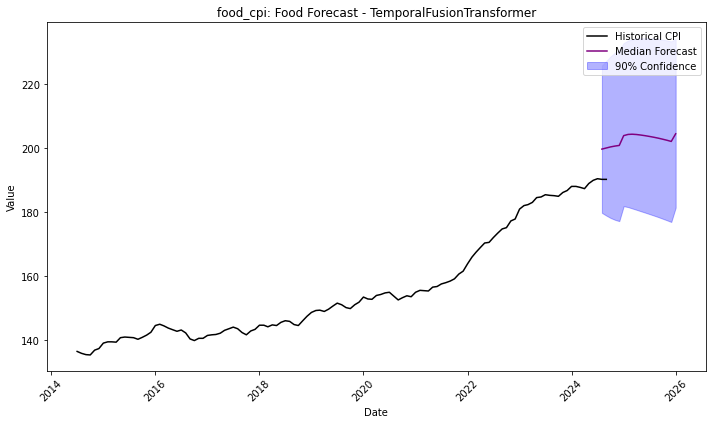

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.032127       0.244802         236.488763   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


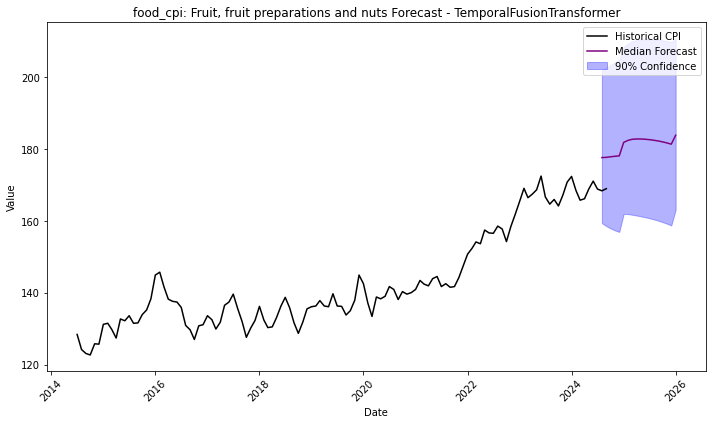

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.032127       0.244802         236.488763   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


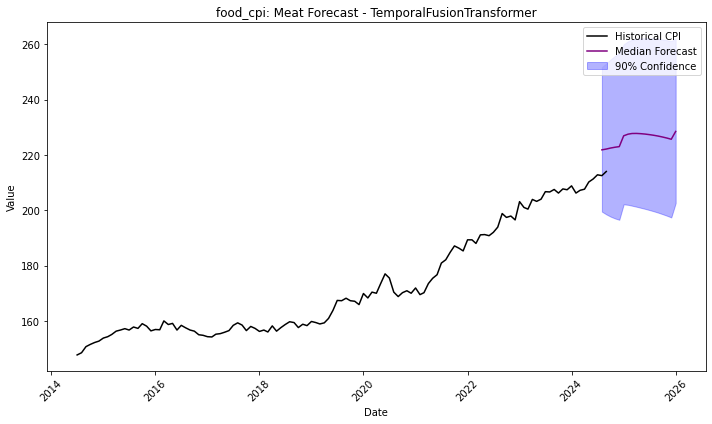

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.032127       0.244802         236.488763   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


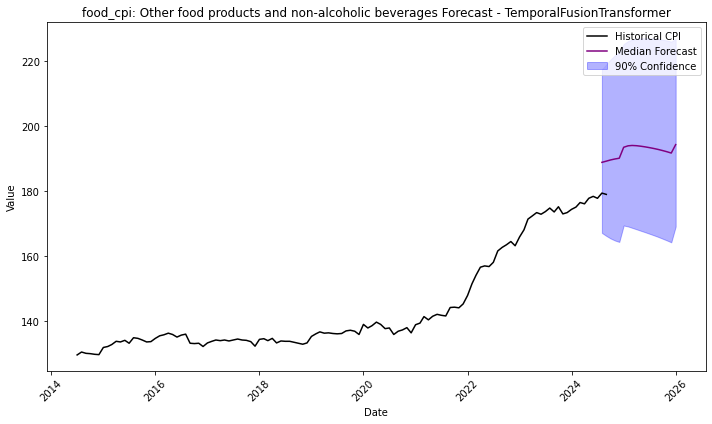

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.032127       0.244802         236.488763   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


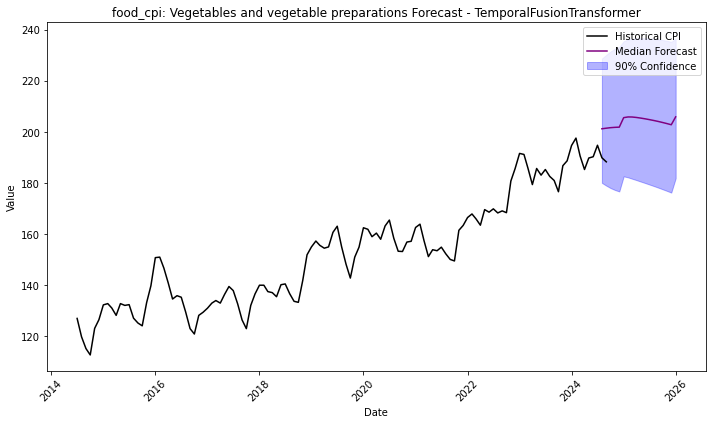

In [34]:
EXP_BASE_LIST_GLOBAL = ["ag_global_cpi_with_covariates"]




for EXP_BASE in EXP_BASE_LIST_GLOBAL:
    EXP_MODEL_LIST = get_model_list(EXP_BASE)
    print(EXP_MODEL_LIST)

    for model_type in EXP_MODEL_LIST:
        print(model_type)
        
        
        EXPERIMENT_NAME = f"{EXP_BASE}_{model_type}"

        for cutoff_date in report_sim_dates:
            forecast_output_dir, plot_output_dir, training_output_dir, model_dir = (
                create_output_directories(
                    exp_test_description,
                    start_year,
                    EXPERIMENT_NAME,
                    cutoff_date,
                    random_seed
                )
            )

            if "_covariates" in EXP_BASE:
                train_data = processor.get_autogluon_global_with_covariates_df(
                    cutoff_date
                )
            else:
                train_data = processor.get_autogluon_global_df(cutoff_date)

            predictor = fit_predictors_global(model_type, model_dir, train_data, random_seed)

            for category in target_categories:
                process_and_plot_forecasts(
                    predictor,
                    train_data,
                    category,
                    training_output_dir,
                    forecast_output_dir,
                    plot_output_dir,
                    foodprice_df,
                    cutoff_date
                )

<AxesSubplot:xlabel='timestamp'>

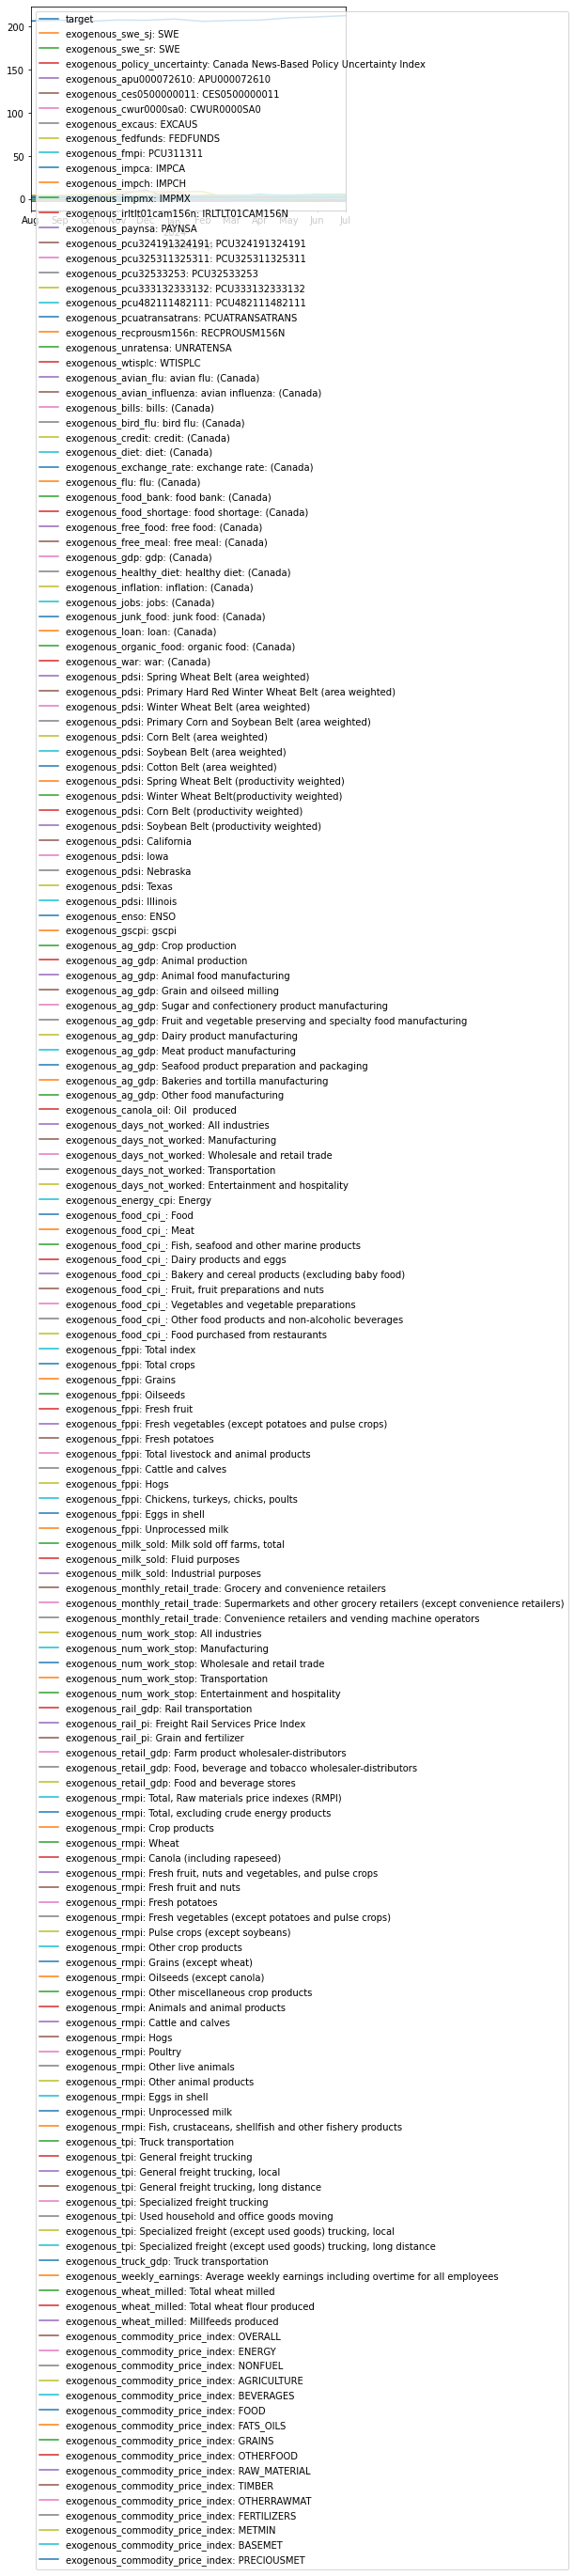

In [78]:
train_data.loc[train_data['item_id'] == 'food_cpi: Meat'].iloc[-12:].set_index('timestamp').plot()

In [82]:
# If `model_base` exists, inspect its attributes
if hasattr(model, 'model_base'):
    print("Model Base Type:", type(model.model_base))
    print("Model Base Attributes:", dir(model.model_base))
    
    # If it has parameters, we can sum them up
    if hasattr(model.model_base, 'parameters'):
        num_params = sum(p.numel() for p in model.model_base.parameters())
        print(f"Total parameters in model_base: {num_params}")
        
# Check if `params_trained` is not empty
if hasattr(model.model_base, 'params_trained') and model.model_base.params_trained:
    print("Model Base Trained Params:", model.model_base.params_trained)
else:
    print("No detailed parameters found in `params_trained`.")

Model Base Type: <class 'autogluon.timeseries.models.gluonts.torch.models.TemporalFusionTransformerModel'>
Model Base Attributes: ['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_ag_params', '_apply_conformalization', '_apply_temperature_scaling', '_calculate_total_resources', '_check_fit_params', '_class_tags', '_compile', '_compiler', '_compute_fit_metadata', '_compute_permutation_importance', '_convert_proba_to_unified_form', '_default_compiler', '_deferred_init_params_aux', '_dummy_gluonts_freq', '_estimate_memory_usage', '_feature_metadata', '_features', '_features_internal', '_fit', '_fit_metadata', '_get_ag_params', '_get_callbacks', '_get_child_aux_v